# Link iNaturalist observations to TRY

Link iNaturalist vascular plant observations to the previously created trait TRY summary statistics.

This section covers:

- Load data
- Link GBIF and TRY
- Fuzzy merge
- Log trait values conversion
- Number of observations per trait
- Plot observation density after linking

(the processing might take a while - you can also download the exports here: https://drive.google.com/drive/folders/1RCWd3yWEy2vW772XsgvOErerrNVMkYZ5?usp=sharing)

## Assignments
- Repeat the workflow but instead of the mean, calculate the standard deviation (for this, you also have to change the workflow in Chapter 2).

## Packages, etc.

In [1]:
import pandas as pd
import os
import numpy as np

# fuzzy matching
#import rapidfuzz
from rapidfuzz import process, fuzz

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
import cartopy.crs as ccrs # plot maps
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Set the path to our working directory (where your data is stored)
working_directory = "G:/My Drive/teaching/2024_msc_remotesensing_geoinformatics/"
os.chdir(working_directory)

## Load data

We load the GBIF vascular plant observations and the TRY summary stats per species.

In [3]:
gbif = pd.read_csv("exports/gbif_preporcessed_subsample.csv") # we will load the data that we subsampled using the hexagons (h3 package)
print(gbif.shape)
gbif.head(3)

(2305270, 15)


,gbifID,decimalLatitude,decimalLongitude,dateIdentified,scientificName,kingdom,phylum,order,family,genus,hasCoordinate,species,decimalLongitude_cell,decimalLatitude_cell,hex
0,2868244889,80.564987,58.774703,2020-09-19T11:35:57,Cochlearia groenlandica L.,Plantae,Tracheophyta,Brassicales,Brassicaceae,Cochlearia,True,Cochlearia groenlandica,120,73,84001a5ffffffff
1,2963894480,80.870095,60.122311,2020-09-19T11:08:46,Saxifraga cernua L.,Plantae,Tracheophyta,Saxifragales,Saxifragaceae,Saxifraga,True,Saxifraga cernua,121,73,84001a7ffffffff
2,2963791473,80.869255,60.115336,2020-09-19T11:08:30,Saxifraga cernua L.,Plantae,Tracheophyta,Saxifragales,Saxifragaceae,Saxifraga,True,Saxifraga cernua,121,73,84001a7ffffffff


Load trait measurments with consolidated species name:

In [9]:
TRY = pd.read_csv("exports/TRY_summary_stats.csv")
print(TRY.shape)
TRY.head()

(49618, 34)


C:\Users\teja\AppData\Local\Temp\ipykernel_13872\2335081165.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  TRY = pd.read_csv("exports/TRY_summary_stats.csv")


,Species,Stem specific density (SSD),Root rooting depth,Specific Leaf Area (SLA),Leaf carbon (C) per mass,Leaf nitrogen (N) per mass,Leaf phosphorus (P) per mass,Plant Height,Seed diameter,Seed mass,...,chromosome cDNA content,Dispersal unit length,Stem conduit diameter,Conduit element length,Wood fibre length,Root length per root dry mass,"Leaf Area (leaflet, petiole undef.)","Leaf Area (leaf, petiole undef.)",Leaf Area (all undefined),Leaf Water content per mass
0,NaN,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
1,ABACABA (PALM),0.67182258,2.188645968,13.752224134999999,474.5692781,25.32521345,1.253181666,8.4296382075,0.2313252895,46.814951185,...,2.4796274765,5.936477324,38.54777807,286.83885685,806.1851291,1540.9771784999998,1629.9629989999999,991.6321591999999,1292.5800945,2.6455549229999997
2,ABIU CASCA,0.49697818080000006,0.8950037030000001,6.2474206146,500.14809206,12.69680008,1.1448929794,13.550312633999999,0.38141308659999995,17.222437812000003,...,30.945200002,11.971509082,12.890331503999999,790.67177572,1499.2807388,1884.3254176000003,127.19104564,164.44703828,134.33358565999998,2.3251470896
3,ABIU CUTITI,0.47722341749999997,0.94460775825,6.634051281375,497.942213275,11.87797663625,1.194187159875,13.245605475,0.157331747125,15.91704585,...,28.611930386250002,11.13826751375,14.919168916250001,777.4280522624999,1436.118488875,2397.98345525,126.66614393750001,179.9558873,155.4498817625,2.269552209125
4,ABIU PITOMBA,0.526880003,1.117701795,6.008566008,499.8086168,12.51477023,1.147831116,14.29486693,0.708226331,17.32767837,...,28.94036888,12.00787732,12.9384099,819.4506614,1483.106728,1452.674352,121.1756689,165.3657456,129.8723178,2.173391932


In [10]:
# check that we have only unique observation ID's
gbif["gbifID"].nunique()

830054

## Link GBIF and TRY

Now we merge the GBIF and TRY data based on the species name. We will at first use a non-fuzzy merge with TRY summary stats on **consolidated TRY species name** (column Species)


In [12]:
gbif_TRY = pd.merge(gbif, TRY, 
                    left_on= ['species'],
                    right_on= ['Species'], 
                    how='inner') # only results in matched records where both datasets have the same species name (alternatives would be "left" and "right")
gbif_TRY.drop(columns=['Species'], inplace=True)
gbif_TRY.head(3)

,gbifID,decimalLatitude,decimalLongitude,dateIdentified,scientificName,kingdom,phylum,order,family,genus,...,chromosome cDNA content,Dispersal unit length,Stem conduit diameter,Conduit element length,Wood fibre length,Root length per root dry mass,"Leaf Area (leaflet, petiole undef.)","Leaf Area (leaf, petiole undef.)",Leaf Area (all undefined),Leaf Water content per mass
0,3008516442,80.565103,58.774792,2020-09-19T11:35:49,Cochlearia groenlandica L.,Plantae,Tracheophyta,Brassicales,Brassicaceae,Cochlearia,...,1.3538341895000001,1.5521512785,45.4763368,252.8841359,513.72170035,6516.6401635,203.54462089999998,162.54112794999998,168.99098909999998,8.2433654665
1,2963827476,80.868920,60.115670,2020-09-19T11:09:54,Saxifraga cespitosa L.,Plantae,Tracheophyta,Saxifragales,Saxifragaceae,Saxifraga,...,2.856464,0.522506,47.872849,883.342535,700.677074,1373.952797,210.978228,76.430093,47.778096,7.667775
2,2999173995,80.337272,52.778900,2020-12-08T10:12:52,Saxifraga cernua L.,Plantae,Tracheophyta,Saxifragales,Saxifragaceae,Saxifraga,...,2.876218,0.903105,37.891138,809.963929,766.030949,1685.371092,240.026906,83.158915,50.954057,6.878179


Check how many of the observations were matched:

In [13]:
print('TRY consolidated species:')
print(TRY["Species"].nunique())
print('GBIF species:')
print(gbif["scientificName"].nunique())
print('Matched species:')
print(gbif_TRY["species"].nunique())

# percentage of iNat observations linked with at least one TRY trait
print('percentage of GBIF observations linked with at least one TRY trait:')
print(round(len(gbif_TRY)/len(gbif)*100, 1), "%")

TRY consolidated species:
49617
GBIF species:
56364
Matched species:
18379
percentage of GBIF observations linked with at least one TRY trait:
75.2 %


## Fuzzy merge
Often, species names have typos or differ in their complexity (e.g. may include author names). The above used matching routine only considers matches when the strings (species names) are exactly the same. To overcome this limitation, we can use fuzzy matching, which can match strings that are relatively similar. The "relatively" can be defined by the parameter ```score_cutoff``` (see below).

In [14]:
gbif_rest = gbif[~gbif.gbifID.isin(gbif_TRY['gbifID'])]
print("Number of unmatched observations", gbif_rest.shape)
print("Number of unmatched species", gbif_rest.species.nunique())

Number of unmatched observations (206045, 15)
Number of unmatched species 31481


Get only unique species names left in gbif unmatched observations:

In [15]:
gbif_rest_unique = gbif_rest.drop_duplicates(subset=['scientificName'])
gbif_rest_unique.head(2)

,gbifID,decimalLatitude,decimalLongitude,dateIdentified,scientificName,kingdom,phylum,order,family,genus,hasCoordinate,species,decimalLongitude_cell,decimalLatitude_cell,hex
1,2963860459,80.869233,60.113906,2020-09-19T11:44:55,Poa abbreviata R.Br.,Plantae,Tracheophyta,Poales,Poaceae,Poa,True,Poa abbreviata,121,72,84001a7ffffffff
36,3044830460,79.558874,17.656721,2020-03-14T18:05:34,Bistorta vivipara (L.) Delarbre,Plantae,Tracheophyta,Caryophyllales,Polygonaceae,Bistorta,True,Bistorta vivipara,99,71,84002d7ffffffff


Get only unique unmatched TRY species names:

In [16]:
TRY_rest = TRY[~TRY.Species.isin(gbif_TRY['species'])]
TRY_rest_unique = TRY_rest.drop_duplicates(subset=['Species'])

TRY_rest_unique.head(2)

,Species,Stem specific density (SSD),Root rooting depth,Specific Leaf Area (SLA),Leaf carbon (C) per mass,Leaf nitrogen (N) per mass,Leaf phosphorus (P) per mass,Plant Height,Seed diameter,Seed mass,...,chromosome cDNA content,Dispersal unit length,Stem conduit diameter,Conduit element length,Wood fibre length,Root length per root dry mass,"Leaf Area (leaflet, petiole undef.)","Leaf Area (leaf, petiole undef.)",Leaf Area (all undefined),Leaf Water content per mass
1,ABACABA (PALM),0.67182258,2.188645968,13.752224134999999,474.5692781,25.32521345,1.253181666,8.4296382075,0.2313252895,46.814951185,...,2.4796274765,5.936477324,38.54777807,286.83885685,806.1851291,1540.9771784999998,1629.9629989999999,991.6321591999999,1292.5800945,2.6455549229999997
2,ABIU CASCA,0.49697818080000006,0.8950037030000001,6.2474206146,500.14809206,12.69680008,1.1448929794,13.550312633999999,0.38141308659999995,17.222437812000003,...,30.945200002,11.971509082,12.890331503999999,790.67177572,1499.2807388,1884.3254176000003,127.19104564,164.44703828,134.33358565999998,2.3251470896


Run the fuzzy matching (this might take a while, ~12 min)

In [17]:
# define choices and queries (expect about 10 minutes to run)
choices = TRY_rest_unique["Species"].apply(str)
queries = gbif_rest_unique["scientificName"]

# score-cutoff is a threshold used on the similarity metric (similarity between choices and queries)
score_sort = [(x,) + i
             for x in queries
             for i in process.extract(x, choices, score_cutoff=90, scorer=fuzz.token_sort_ratio) ]

fuzzy_matches = pd.DataFrame(score_sort)
fuzzy_matches.head()

,0,1,2,3
0,Juncus trifidus L.,Juncus trifidus,90.909091,25079
1,Monotropa hypopitys L.,Monotropa hypopitys,92.682927,30587
2,Hypochaeris maculata L.,Hypochaeris maculata,93.023256,23709
3,Elaeagnus angustifolia L.,Eleagnus angustifolia,91.304348,16028
4,Scorzonera hispanica L.,Scorzonera hispanica,93.023256,41830


This can be quite a long process. Let´s store the data just in case. Save fuzzy match to ```.csv```:

In [18]:
os.makedirs("exports", exist_ok=True)
fuzzy_matches.to_csv("exports/TRY_gbif_fuzzy_matches.csv", sep = "\t",index=False)

Reload fuzzy matches:

In [19]:
fuzzy_matches =  pd.read_csv("exports/TRY_gbif_fuzzy_matches.csv", sep = "\t")
fuzzy_matches.head()

,0,1,2,3
0,Juncus trifidus L.,Juncus trifidus,90.909091,25079
1,Monotropa hypopitys L.,Monotropa hypopitys,92.682927,30587
2,Hypochaeris maculata L.,Hypochaeris maculata,93.023256,23709
3,Elaeagnus angustifolia L.,Eleagnus angustifolia,91.304348,16028
4,Scorzonera hispanica L.,Scorzonera hispanica,93.023256,41830


Rename the columns and merge with the data frame of the unmatched observations


In [20]:
fuzzy_matches.rename(columns = {'0':'scientificName'}, inplace = True)
fuzzy_matches.rename(columns = {'1':'fuzzyName'}, inplace = True)
gbif_rest_fuzzy = pd.merge(gbif_rest, fuzzy_matches, on='scientificName', how='inner')

Merge with TRY:

In [21]:
TRY = pd.read_csv("exports/TRY_summary_stats.csv")

TRY.rename(columns = {'Species':'fuzzyName'}, inplace = True)
gbif_TRY_fuzzy_1 = pd.merge(gbif_rest_fuzzy, TRY, on='fuzzyName', how='inner')

#gbif_TRY_fuzzy_rest = gbif_rest_fuzzy[~gbif_rest_fuzzy.gbifID.isin(gbif_TRY_fuzzy_1['gbifID'])]

# drop the by products (columns) from the fuzzy matching
gbif_TRY_fuzzy_1= gbif_TRY_fuzzy_1.drop(columns=["fuzzyName", "2", "3"])


C:\Users\teja\AppData\Local\Temp\ipykernel_13872\742126083.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  TRY = pd.read_csv("exports/TRY_summary_stats.csv")


In [22]:
print("shape", gbif_TRY_fuzzy_1.shape)
gbif_TRY_fuzzy_1.head(1)

shape (1023, 48)


,gbifID,decimalLatitude,decimalLongitude,dateIdentified,scientificName,kingdom,phylum,order,family,genus,...,chromosome cDNA content,Dispersal unit length,Stem conduit diameter,Conduit element length,Wood fibre length,Root length per root dry mass,"Leaf Area (leaflet, petiole undef.)","Leaf Area (leaf, petiole undef.)",Leaf Area (all undefined),Leaf Water content per mass
0,2429230519,65.612759,-37.64232,2019-10-11T20:10:21,Juncus trifidus L.,Plantae,Tracheophyta,Poales,Juncaceae,Oreojuncus,...,2.597548,1.17761,21.902522,251.509898,454.905331,2681.874184,88.674402,89.325221,87.125708,3.003286


In [23]:
print("gbif_TRY:", gbif_TRY.shape)
print("gbif_TRY_fuzzy:", gbif_TRY_fuzzy_1.shape)

gbif_TRY: (624009, 48)
gbif_TRY_fuzzy: (1023, 48)


At least more than 1000 observations could be matched this way. Let´s check if these observations have duplicates with the already matched observations:

In [24]:
gbif_TRY.gbifID.isin(gbif_TRY_fuzzy_1.gbifID).sum()

0

In [25]:
# merge fuzzy-consolidated species name match and fuzzy-original match
gbif_TRY = pd.concat([gbif_TRY, gbif_TRY_fuzzy_1])

Drop gbif observation duplicates in fuzzy matches, keeping the row with the least NaN

In [26]:
gbif_TRY = (gbif_TRY.assign(counts=gbif_TRY.count(axis=1))
   .sort_values(['gbifID', 'counts'])
   .drop_duplicates('gbifID', keep='last')
   .drop('counts', axis=1))

After matching with alternate name and a conservative fuzzy match, we were able to match about 75% of the iNaturalist observations with trait information. Many rare species seem to be absent in either one of the two databases.


In [27]:

# percentage of iNat observations linked with at least one TRY trait
print('percentage of gbif observations linked with at least one TRY trait:')
print(round(len(gbif_TRY)/len(gbif)*100, 1), "%")

percentage of gbif observations linked with at least one TRY trait:
75.3 %


In [28]:
gbif_TRY.head()

,gbifID,decimalLatitude,decimalLongitude,dateIdentified,scientificName,kingdom,phylum,order,family,genus,...,chromosome cDNA content,Dispersal unit length,Stem conduit diameter,Conduit element length,Wood fibre length,Root length per root dry mass,"Leaf Area (leaflet, petiole undef.)","Leaf Area (leaf, petiole undef.)",Leaf Area (all undefined),Leaf Water content per mass
332093,891019304,47.684845,-122.589408,2012-02-11T00:45:13,Taxus brevifolia Nutt.,Plantae,Tracheophyta,Pinales,Taxaceae,Taxus,...,20.832443,5.470958,9.644997,385.77752,819.590424,182.146146,31.414017,31.695023,24.045295,2.736272
315758,891019473,38.449024,-122.704169,2012-03-17T22:47:21,Bellis perennis L.,Plantae,Tracheophyta,Asterales,Asteraceae,Bellis,...,3.817531062304,1.618620007888,26.96552509376,447.993463832,776.3820149128001,8276.057340552,390.49276662479997,394.7697246528,1454.0577747944,7.873485920944
522619,891021129,34.808273,-111.771296,2012-10-04T01:57:30,Canotia holacantha Torr.,Plantae,Tracheophyta,Celastrales,Celastraceae,Canotia,...,2.3620321867142855,4.681531285714286,43.635880435714284,575.3827435857144,1026.547983,716.2532876142858,2016.390379142857,1232.7633135714284,2887.3163678571427,3.2455433645714287
352869,891021463,35.161813,-118.578242,2012-09-29T16:30:32,Frangula californica (Eschsch.) A.Gray,Plantae,Tracheophyta,Rosales,Rhamnaceae,Frangula,...,1.211257,11.610082,28.234902,315.356419,533.008349,3499.508456,1025.445502,993.351851,904.922028,3.391295
312349,891021564,40.442529,-121.528058,2012-10-09T23:27:01,Monardella odoratissima Benth.,Plantae,Tracheophyta,Lamiales,Lamiaceae,Monardella,...,2.50282,1.642122,29.124253,333.639568,572.401693,3940.445464,413.594924,586.5515,303.403342,4.728284


In [29]:
gbif_TRY.to_csv("exports/gbif_TRY.csv", index=False)

## Log trait values

Often trait data are log-transformed since traits often show a very skewed distribution (a lot of generalists but few specialists).
The cwm in sPlot were caluclated after being log e transformed, so we must log e transform gbif data also:

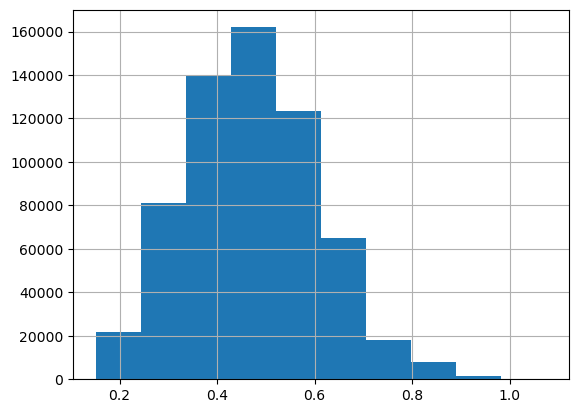

In [30]:
gbif_TRY.iloc[:, 15] = pd.to_numeric(gbif_TRY.iloc[:, 15], errors='coerce')
gbif_TRY.iloc[:, 15].hist()
plt.show()

In [31]:
trait = gbif_TRY.columns[15:]
gbif_TRY[trait] = gbif_TRY[trait].applymap(lambda x: pd.to_numeric(x, errors='coerce'))
gbif_TRY[trait] = np.log(gbif_TRY[trait])
gbif_TRY.head()

C:\Users\teja\AppData\Local\Temp\ipykernel_13872\187295502.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  gbif_TRY[trait] = gbif_TRY[trait].applymap(lambda x: pd.to_numeric(x, errors='coerce'))
c:\Users\teja\miniforge3\envs\msc_remote_sens_2024\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,gbifID,decimalLatitude,decimalLongitude,dateIdentified,scientificName,kingdom,phylum,order,family,genus,...,chromosome cDNA content,Dispersal unit length,Stem conduit diameter,Conduit element length,Wood fibre length,Root length per root dry mass,"Leaf Area (leaflet, petiole undef.)","Leaf Area (leaf, petiole undef.)",Leaf Area (all undefined),Leaf Water content per mass
332093,891019304,47.684845,-122.589408,2012-02-11T00:45:13,Taxus brevifolia Nutt.,Plantae,Tracheophyta,Pinales,Taxaceae,Taxus,...,3.036512,1.699454,2.266439,5.955261,6.708805,5.204809,3.447254,3.456160,3.179939,1.006596
315758,891019473,38.449024,-122.704169,2012-03-17T22:47:21,Bellis perennis L.,Plantae,Tracheophyta,Asterales,Asteraceae,Bellis,...,1.339604,0.481574,3.294559,6.104779,6.654645,9.021122,5.967409,5.978303,7.282113,2.063501
522619,891021129,34.808273,-111.771296,2012-10-04T01:57:30,Canotia holacantha Torr.,Plantae,Tracheophyta,Celastrales,Celastraceae,Canotia,...,0.859522,1.543625,3.775880,6.355035,6.933957,6.574034,7.609064,7.117014,7.968083,1.177283
352869,891021463,35.161813,-118.578242,2012-09-29T16:30:32,Frangula californica (Eschsch.) A.Gray,Plantae,Tracheophyta,Rosales,Rhamnaceae,Frangula,...,0.191659,2.451874,3.340559,5.753703,6.278537,8.160378,6.932882,6.901085,6.807849,1.221212
312349,891021564,40.442529,-121.528058,2012-10-09T23:27:01,Monardella odoratissima Benth.,Plantae,Tracheophyta,Lamiales,Lamiaceae,Monardella,...,0.917418,0.495989,3.371571,5.810061,6.349841,8.279049,6.024887,6.374260,5.715063,1.553562


In [32]:
gbif_TRY = gbif_TRY.replace(-np.inf, np.nan)
gbif_TRY = gbif_TRY.replace(np.inf, np.nan)

In [33]:
gbif_TRY.to_csv("exports/gbif_TRY_log.csv", index=False)

## Number of observations per trait

In [34]:
gbif_TRY.count().round(decimals = 1)

gbifID                                      625028
decimalLatitude                             625028
decimalLongitude                            625028
dateIdentified                              622923
scientificName                              625028
kingdom                                     625028
phylum                                      625028
order                                       625028
family                                      625028
genus                                       625009
hasCoordinate                               625028
species                                     621805
decimalLongitude_cell                       625028
decimalLatitude_cell                        625028
hex                                         625028
Stem specific density (SSD)                 621805
Root rooting depth                          621805
Specific Leaf Area (SLA)                    621805
Leaf carbon (C) per mass                    621805
Leaf nitrogen (N) per mass     

## Density of observations after linking GBIF and TRY

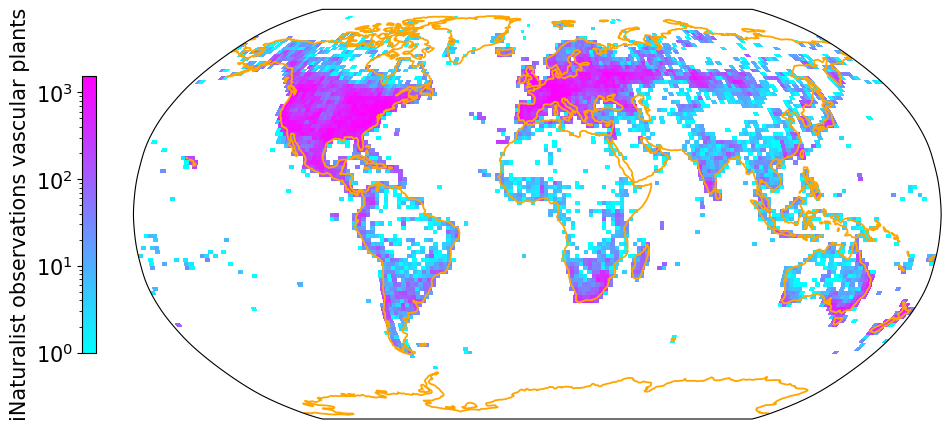

In [36]:
plt.rcParams.update({'font.size': 15})

Z, xedges, yedges = np.histogram2d(np.array(gbif_TRY['decimalLongitude'],dtype=float),
                                   np.array(gbif_TRY['decimalLatitude']),bins = [181, 91])

data_crs = ccrs.PlateCarree()
#for colorbar
cmap = plt.get_cmap('cool')
im_ratio = Z.shape[0]/Z.shape[1]

#plot map
fig = plt.figure(figsize=(12, 12)) # I created a new figure and set up its size

#create base plot of a world map
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson()) # I used the PlateCarree projection from cartopy
ax.set_global()
#add coastlines
ax.coastlines(resolution='110m', color='orange', linewidth=1.3)
#add grid with values
im = ax.pcolormesh(xedges, yedges, Z.T, cmap="cool", norm=LogNorm(), transform=data_crs)
#add color bar
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="3%", pad=0.05)
#fig.colorbar(im, cax=cax)
fig.colorbar(im,fraction=0.046*im_ratio, pad=0.04, shrink=0.3, location="left", label="iNaturalist observations vascular plants")


plt.savefig('figures/iNat_density_Robinson_TRY.pdf', bbox_inches='tight')

